# **Necessary Modules Installation**

---



In [1]:
!pip install zetascale swarms datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fastmcp to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of fastmcp to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 M

# **Data Preparation**

---



In [1]:
import os
import cv2
import json
import torch
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from torch import nn, Tensor
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [2]:
ROOT_DIR = "/content/Data_122824"
TRAINING_DIR = os.path.join(ROOT_DIR, "Glioma_MDC_2025_training")
TEST_DIR = os.path.join(ROOT_DIR, "Glioma_MDC_2025_test")


ROI_PADDING = 10 # means 10 left, 10 right , 10 top 10 bottom
ORIGINAL_COORDS = 1015
MAPPED_COORDS = 512

BATCH_SIZE = 4
ROI_DIMS = (64, 64)
PATCH_SIZE = (8, 8)
PATCH_STRIDE = (8, 8)
SEED = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [4]:
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [5]:
if not os.path.exists("glioma-mcd-2025.zip"):
  !kaggle competitions download -c glioma-mcd-2025
  !unzip glioma-mcd-2025.zip
  !rm -rf /content/archive

Streaming output truncated to the last 5000 lines.
  inflating: Data_122824/Glioma_MDC_2025_training/training0580.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0580.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0581.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0581.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0582.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0582.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0583.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0583.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0584.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0584.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0585.jpg  
  inflating: Data_122824/Glioma_MDC_2025_training/training0585.json  
  inflating: Data_122824/Glioma_MDC_2025_training/training0586.jpg  
  inflating: Data_122824/Glioma_MDC_2025_train

In [6]:
def mini_max_norm(image):
  return (image-image.min())/(image.max()-image.min())

In [7]:
def load_data(annotation_dir=Path(TRAINING_DIR)):
  X = []
  Y = []
  for json_file in annotation_dir.glob("*.json"):
    img_path = os.path.join(TRAINING_DIR, json_file.name.replace(".json", ".jpg"))
    img = plt.imread(img_path)
    with open(json_file) as f:
        data = json.load(f)
        shapes = data.get('shapes')
        height = data.get('imageHeight')
        width = data.get('imageWidth')

        wh_vector = np.array([width, height], dtype=float)

        for shape in shapes:
          label = shape.get('label').lower()
          points = np.array(shape.get('points'))
          if height == 512 and width == 512 and points.max() > 512:
            print(f"mismatched: {json_file}")
            continue

          points = (points/wh_vector) * MAPPED_COORDS
          min_x, min_y = points.min(axis=0)
          max_x, max_y = points.max(axis=0)

          min_x, min_y = int(min_x), int(min_y)
          max_x, max_y = int(max_x), int(max_y)

          # img = cv2.rectangle(img.copy(), (min_x,min_y), (max_x, max_y), (255,0,0), 1)

          min_y = min_y - ROI_PADDING if min_y - ROI_PADDING >= 0 else min_y
          min_x = min_x - ROI_PADDING if min_x - ROI_PADDING >= 0 else min_x

          max_y = max_y + ROI_PADDING if max_y + ROI_PADDING < 512 else max_y
          max_x = max_x + ROI_PADDING if max_x + ROI_PADDING < 512 else max_x

          roi = img[min_y:max_y, min_x: max_x]

          X.append(roi)
          Y.append(label)

          # plt.figure(figsize=(5,5))
          # plt.title(label)
          # plt.imshow(roi)
          # plt.figure(figsize=(5,5))
          # plt.imshow(img)

  return X, Y

X,Y = load_data()

mismatched: /content/Data_122824/Glioma_MDC_2025_training/training0002.json


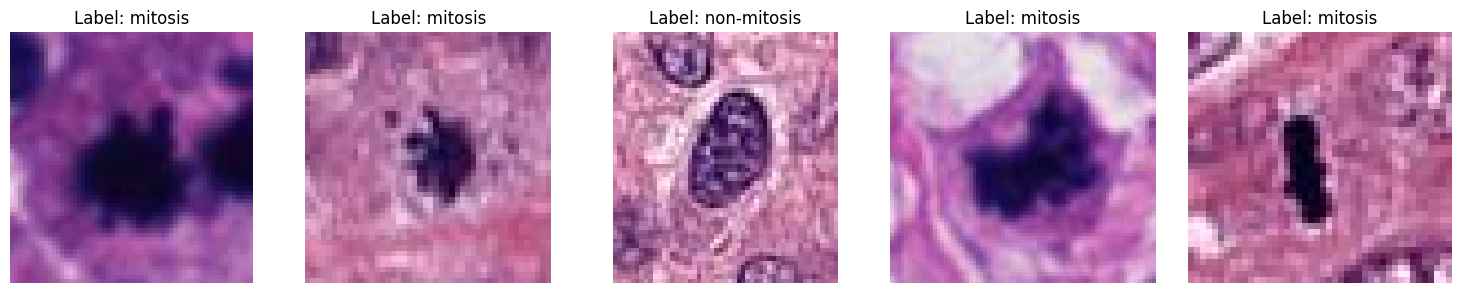

In [8]:
def visualize(X, Y, num_samples=5):
  indices = random.sample(range(len(X)), num_samples)

  fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

  for ax, idx in zip(axes, indices):
      img = X[idx]

      ax.imshow(img)

      ax.set_title(f"Label: {Y[idx]}")
      ax.axis('off')

  plt.tight_layout()
  plt.show()

visualize(X,Y)

In [9]:
def print_data_stats(X, Y):
  assert len(X) == len(Y)
  print(f"Data Length is {len(X)}")
  avg_height = 0
  avg_width = 0

  for img in X:
    height, width = img.shape[:2]
    avg_height +=height
    avg_width +=width

  avg_height/=len(X)
  avg_width/=len(X)
  print(f"Avg Images Height is {avg_height}")
  print(f"Avg Images Height is {avg_width}")

  non_mitosis_images = [i for i, label in enumerate(Y) if label == "non-mitosis" or label == 0]
  mitosis_images  = [i for i, label in enumerate(Y) if label == "mitosis" or label == 1]

  print(f"Non Mitoses length images {len(non_mitosis_images)}")
  print(f"Mitoses length images {len(mitosis_images)}")

  diff = len(mitosis_images) - len(non_mitosis_images)
  print(f"Difference: {diff}")

In [10]:
print_data_stats(X, Y)

Data Length is 1615
Avg Images Height is 61.60433436532508
Avg Images Height is 62.869349845201235
Non Mitoses length images 726
Mitoses length images 889
Difference: 163


#### **Augmentation**

---



In [11]:
def augment_roi(roi):
    if random.random() > 0.5:
        roi = np.fliplr(roi)

    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((roi.shape[1] // 2, roi.shape[0] // 2), angle, 1)
        roi = cv2.warpAffine(roi, M, (roi.shape[1], roi.shape[0]))

    if random.random() > 0.5 and roi.shape[0] >= ROI_DIMS[0] and roi.shape[1] >= ROI_DIMS[1]:
        start_x = random.randint(0, roi.shape[1] - ROI_DIMS[0])
        start_y = random.randint(0, roi.shape[0] - ROI_DIMS[1])
        roi = roi[start_y:start_y + ROI_DIMS[1], start_x:start_x + ROI_DIMS[0]]

    return roi

def augment_data_balanced(X, Y):
    mitosis_X = [x for x, y in zip(X, Y) if y == 'mitosis']
    mitosis_Y = ['mitosis'] * len(mitosis_X)

    non_mitosis_X = [x for x, y in zip(X, Y) if y == 'non-mitosis']
    non_mitosis_Y = ['non-mitosis'] * len(non_mitosis_X)

    needed = len(mitosis_X) - len(non_mitosis_X)

    augmented_non_X = []
    augmented_non_Y = []

    while len(augmented_non_X) < needed:
        random.shuffle(non_mitosis_X)
        for roi in non_mitosis_X:
            if len(augmented_non_X) >= needed:
                break
            augmented_roi = augment_roi(roi)
            augmented_non_X.append(augmented_roi)
            augmented_non_Y.append('non-mitosis')

    final_X = mitosis_X + non_mitosis_X + augmented_non_X
    final_Y = mitosis_Y + non_mitosis_Y + augmented_non_Y

    return final_X, final_Y

final_X, final_Y = augment_data_balanced(X, Y)

In [12]:
final_X_resized = []
for roi in final_X:
    resized_roi = cv2.resize(roi, ROI_DIMS, interpolation=cv2.INTER_CUBIC)
    norm_roi = mini_max_norm(resized_roi)
    final_X_resized.append(norm_roi)

final_Y_mapped = []
for y in final_Y:
  val = 1 if y == "mitosis" else 0
  final_Y_mapped.append(val)

X_prepared = np.array(final_X_resized)
Y_prepared = np.array(final_Y_mapped)

In [13]:
print_data_stats(X_prepared, Y_prepared)

Data Length is 1778
Avg Images Height is 64.0
Avg Images Height is 64.0
Non Mitoses length images 889
Mitoses length images 889
Difference: 0


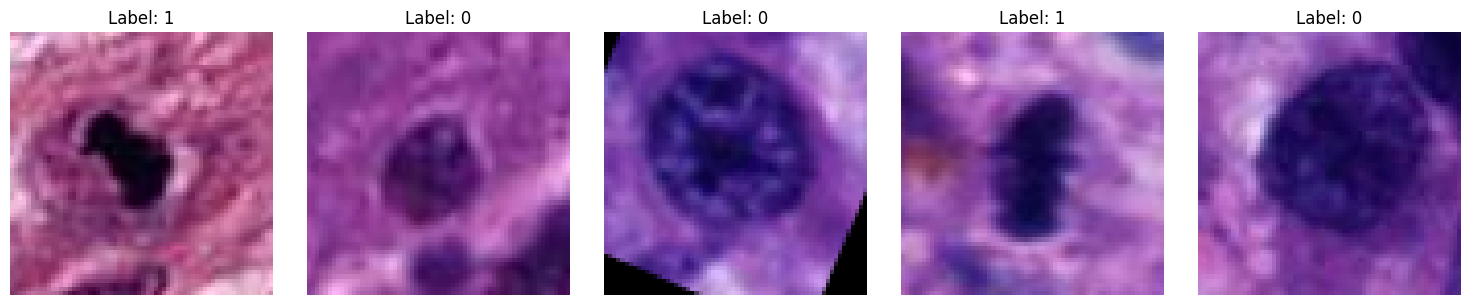

In [14]:
visualize(X_prepared, Y_prepared)

In [15]:
print(X_prepared.shape, Y_prepared.shape)

(1778, 64, 64, 3) (1778,)


In [16]:
print(X_prepared.max(),X_prepared.min())

1.0 0.0


# **Model Definitions**

---



#### **Typical Model**

---



In [22]:
class TypicalCNNModel(nn.Module):
  def __init__(self) -> None:
     super().__init__()
     self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),

        nn.Linear(128*6*6, 128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)


#### **Vision Mamba**

---



In [23]:
from zeta.nn import SSM
from einops import rearrange, repeat
from einops.layers.torch import Reduce
from einops.layers.torch import Rearrange

**Encoder**

In [24]:
class VisionEncoderMambaBlock(nn.Module):

    def __init__(
        self,
        dim: int,
        dt_rank: int,
        dim_inner: int,
        d_state: int,
    ):
        super().__init__()
        self.dim = dim
        self.dt_rank = dt_rank
        self.dim_inner = dim_inner
        self.d_state = d_state

        self.forward_conv1d = nn.Conv1d(
            in_channels=dim, out_channels=dim, kernel_size=1
        )

        self.backward_conv1d = nn.Conv1d(
            in_channels=dim, out_channels=dim, kernel_size=1
        )
        self.norm = nn.LayerNorm(dim)
        self.silu = nn.SiLU()
        self.ssm = SSM(dim, dt_rank, dim_inner, d_state)

        self.proj = nn.Linear(dim, dim)

        self.softplus = nn.Softplus()

    def process_direction(
        self,
        x: Tensor,
        conv1d: nn.Conv1d,
        ssm: SSM,
    ):
        x = rearrange(x, "b s d -> b d s")
        x = self.softplus(conv1d(x))

        x = rearrange(x, "b d s -> b s d")
        x = self.ssm(x)

        return x

    def forward(self, x: torch.Tensor):
        b, s, d = x.shape
        skip = x

        x = self.norm(x)

        z1 = self.proj(x)
        x = self.proj(x)

        x_forward = self.process_direction(
            x,
            self.forward_conv1d,
            self.ssm,
        )

        x_backward = self.process_direction(
            x,
            self.backward_conv1d,
            self.ssm,
        )

        z = self.silu(z1)

        x_forward *= z
        x_backward *= z
        x_return = x_forward + x_backward + skip

        return x_return


**Output_head**

In [25]:
def build_output_head(head_type: str, dim: int, **kwargs):
    if head_type == "cnn":
        h = kwargs.get("h")
        w = kwargs.get("w")
        return CNNOutputHead(dim, h, w)

    elif head_type == "resnet-mlp":
        num_blocks = kwargs.get("num_blocks", 2)
        return ResNetMLPOutputHead(dim, num_blocks=num_blocks)

    elif head_type == "default":
        return DefaultOutputHead(dim)

    else:
        raise ValueError(f"Unknown head_type: {head_type}")

In [34]:
class CNNOutputHead(nn.Module):
    def __init__(self, dim: int, h: int, w: int):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            Rearrange("b (h w) d -> b d h w", h=h, w=w),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.cnn_layers(x[:, 1:])
######################################################################
class ResidualMLPBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.linear2 = nn.Linear(dim, dim)
        self.norm2 = nn.LayerNorm(dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.norm2(x)
        x = x + identity
        x = self.relu(x)
        return x

class ResNetMLPOutputHead(nn.Module):
    def __init__(self, dim: int, num_blocks: int = 2):
        super().__init__()
        blocks = [ResidualMLPBlock(dim) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.pool = Reduce("b s d -> b d", "mean")
        self.final = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.res_blocks(x)
        x = self.pool(x)
        return self.final(x)

##################################################################

class DefaultOutputHead(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.head = nn.Sequential(
            Reduce("b s d -> b d", "mean"),
            nn.LayerNorm(dim),
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      return self.head(x)

In [28]:
def output_head(dim: int, head_type, h=8, w=8):
    return build_output_head(
        head_type=head_type,
        dim=dim,
        h=h,
        w=w
    )

In [32]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class Vim(nn.Module):

    def __init__(
        self,
        dim: int = 192,
        dt_rank: int = 16,
        dim_inner: int = 192,
        d_state: int = 8,
        image_size: int = 64,
        patch_size: int = 8,
        channels: int = 3,
        dropout: float = 0.1,
        depth: int = 8,
        head_type = "default",
        multi_scale_patches = None,
        *args,
        **kwargs,
    ):
        print(f"Using Head {head_type}")
        super().__init__()
        self.dim = dim
        self.dt_rank = dt_rank
        self.dim_inner = dim_inner
        self.d_state = d_state
        self.image_size = image_size
        self.patch_size = patch_size
        self.channels = channels
        self.dropout = dropout
        self.depth = depth

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        patch_dim = channels * patch_height * patch_width

        if multi_scale_patches is None:
              self.patch_sizes = [pair(patch_size)]
        else:
              self.patch_sizes = [pair(p) for p in multi_scale_patches]

        for (p_h, p_w) in self.patch_sizes:
            if image_height % p_h != 0 or image_width % p_w != 0:
                  raise ValueError(f"Image size ({image_height}, {image_width}) must be divisible by patch size ({p_h}, {p_w})")


        self.patch_embeddings = nn.ModuleList()
        for (p_h, p_w) in self.patch_sizes:
            patch_dim = self.channels * p_h * p_w  # <-- Use self.channels for consistency
            emb = nn.Sequential(
                Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p_h, p2=p_w),
                nn.Linear(patch_dim, dim)
            )
            self.patch_embeddings.append(emb)

        self.dropout = nn.Dropout(dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.to_latent = nn.Identity()

        self.layers = nn.ModuleList()

        for _ in range(depth):
            self.layers.append(
                VisionEncoderMambaBlock(
                    dim=dim,
                    dt_rank=dt_rank,
                    dim_inner=dim_inner,
                    d_state=d_state,
                    *args,
                    **kwargs,
                )
            )
        if head_type == "cnn" and multi_scale_patches is not None:
          self.output_head = output_head(dim, head_type, h=10, w=8)
        else:
          self.output_head = output_head(dim, head_type)

        print(self.output_head)

    def forward(self, x: Tensor):
        b, c, h, w = x.shape

        x_tokens = [emb(x) for emb in self.patch_embeddings]
        x = torch.cat(x_tokens, dim=1)

        cls_tokens = repeat(self.cls_token, "() n d -> b n d", b=b)

        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x)

        x = self.to_latent(x)

        return self.output_head(x)

# **Initial Model Training**

---



In [30]:
def train_and_eval_model(epochs,
                         model,
                         train_loader,
                         val_loader,
                         criterion,
                         optimizer,
                         train_subset,
                         val_subset):

  history = {'train_loss': [], 'val_loss': [],
               'accuracy': [], 'recall': [], 'f1': []}

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_subset)
    history['train_loss'].append(epoch_loss)

    model.eval()
    val_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    val_loss = val_loss / len(val_subset)
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    history['recall'].append(recall)
    history['f1'].append(f1)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f} Accuracy: {accuracy}")

  return history


def train_K_models(X,
                   Y,
                   model_class=TypicalCNNModel,
                   criterion=nn.BCELoss(),
                   optimizer_class = torch.optim.Adam,
                   epochs=40,
                   **model_kwargs,
                  ):

  X_tensor = torch.tensor(X).float().permute(0, 3, 1, 2)
  Y_tensor = torch.tensor(Y).float()
  full_dataset = TensorDataset(X_tensor, Y_tensor)

  skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

  models_stats = []
  for fold_idx, (train_idx, val_idx) in enumerate(skfold.split(X, Y)):
      fold_id = fold_idx+1
      print(f"Starting Fold {fold_id}")

      model = model_class(**model_kwargs)
      model = model.to(DEVICE)

      optimizer = optimizer_class(model.parameters(), lr=1e-4)

      train_subset = Subset(full_dataset, train_idx)
      val_subset = Subset(full_dataset, val_idx)

      train_loader = DataLoader(
            train_subset,
            batch_size=BATCH_SIZE,
            shuffle=True,
      )

      val_loader = DataLoader(
            val_subset,
            batch_size=BATCH_SIZE,
            shuffle=False
      )
      model_stats = train_and_eval_model(epochs,
                                         model,
                                         train_loader,
                                         val_loader,
                                         criterion,
                                         optimizer,
                                         train_subset,
                                         val_subset
                                      )


      models_stats.append(model_stats)
  return models_stats

CNN Trial

In [ ]:
typical_models_stats = train_K_models(X_prepared, Y_prepared)

Starting Fold 1
Epoch 1/40 - Train Loss: 0.5666, Val Loss: 0.3170 Accuracy: 0.8848314606741573
Epoch 2/40 - Train Loss: 0.2844, Val Loss: 0.2626 Accuracy: 0.9073033707865169
Epoch 3/40 - Train Loss: 0.2542, Val Loss: 0.2616 Accuracy: 0.9101123595505618
Epoch 4/40 - Train Loss: 0.2400, Val Loss: 0.2234 Accuracy: 0.9129213483146067
Epoch 5/40 - Train Loss: 0.2125, Val Loss: 0.2111 Accuracy: 0.9185393258426966
Epoch 6/40 - Train Loss: 0.1958, Val Loss: 0.2048 Accuracy: 0.9185393258426966
Epoch 7/40 - Train Loss: 0.1770, Val Loss: 0.2343 Accuracy: 0.9241573033707865
Epoch 8/40 - Train Loss: 0.1814, Val Loss: 0.2012 Accuracy: 0.9129213483146067
Epoch 9/40 - Train Loss: 0.1696, Val Loss: 0.1848 Accuracy: 0.9382022471910112
Epoch 10/40 - Train Loss: 0.1638, Val Loss: 0.1847 Accuracy: 0.9297752808988764
Epoch 11/40 - Train Loss: 0.1574, Val Loss: 0.1923 Accuracy: 0.9241573033707865
Epoch 12/40 - Train Loss: 0.1380, Val Loss: 0.2679 Accuracy: 0.9073033707865169
Epoch 13/40 - Train Loss: 0.1315,

# VM Trials

In [ ]:
# (VIM default head)
vim_models_stats_default_head = train_K_models(X_prepared, Y_prepared, model_class=Vim)

Starting Fold 1
Using Head default
DefaultOutputHead(
  (head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=192, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Epoch 1/40 - Train Loss: 0.5690, Val Loss: 0.4394 Accuracy: 0.8314606741573034
Epoch 2/40 - Train Loss: 0.3491, Val Loss: 0.3285 Accuracy: 0.8735955056179775
Epoch 3/40 - Train Loss: 0.3035, Val Loss: 0.3462 Accuracy: 0.8764044943820225
Epoch 4/40 - Train Loss: 0.2971, Val Loss: 0.2497 Accuracy: 0.9101123595505618
Epoch 5/40 - Train Loss: 0.2597, Val Loss: 0.2541 Accuracy: 0.9129213483146067
Epoch 6/40 - Train Loss: 0.2558, Val Loss: 0.2448 Accuracy: 0.9101123595505618
Epoch 7/40 - Train Loss: 0.2458, Val Loss: 0.2908 Accuracy: 0.8707865168539326
Epoch 8/40 - Train Loss: 0.2419, Val Loss: 0.2568 Accuracy: 0.9213483146067416
Epoch 9/40 - Train Loss: 0.2637, Val Loss: 0.3195 Accuracy: 0.8820224719101124
Epoch 10/40 - Train Loss:

In [ ]:
# resnet head
vim_models_stats_resnet_head = train_K_models(X_prepared, Y_prepared, model_class=Vim, head_type="resnet-mlp")

Starting Fold 1
Using Head resnet-mlp
ResNetMLPOutputHead(
  (res_blocks): Sequential(
    (0): ResidualMLPBlock(
      (linear1): Linear(in_features=192, out_features=192, bias=True)
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=192, out_features=192, bias=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ResidualMLPBlock(
      (linear1): Linear(in_features=192, out_features=192, bias=True)
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=192, out_features=192, bias=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (pool): Reduce('b s d -> b d', 'mean')
  (final): Sequential(
    (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)
Epoch 1/40 - Train Loss: 0.7078, 

In [ ]:
# CNN head
vim_models_stats_cnn_head = train_K_models(X_prepared, Y_prepared, model_class=Vim, head_type="cnn")

Starting Fold 1
Using Head cnn
CNNOutputHead(
  (cnn_layers): Sequential(
    (0): Rearrange('b (h w) d -> b d h w', h=8, w=8)
    (1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=192, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Epoch 1/40 - Train Loss: 0.4934, Val Loss: 0.6069 Accuracy: 0.7134831460674157
Epoch 2/40 - Train Loss: 0.4005, Val Loss: 0.4683 Accuracy: 0.7359550561797753
Epoch 3/40 - Train Loss: 0.3709, Val Loss: 0.2594 Accuracy: 0.9044943820224719
Epoch 4/40 - Train Loss: 0.3561, Val Loss: 0.4040 Accuracy: 0.8314606741573034
Epoch 5/40 - Train Loss: 0.3106, Val Loss: 0.2366 Accuracy: 0.9269662921348315
Epoch 6/40 - Train Loss: 0.3171, Val Loss: 0.2446 Accuracy: 0.9101123595505618
Epoch 7/40 - Train Loss: 0.2937, Val Loss:

In [38]:
vim_models_stats_cnn_head_mspe = train_K_models(X_prepared, Y_prepared, model_class=Vim, head_type="cnn", multi_scale_patches=[8, 16])

Starting Fold 1
Using Head cnn
CNNOutputHead(
  (cnn_layers): Sequential(
    (0): Rearrange('b (h w) d -> b d h w', h=10, w=8)
    (1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=192, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Epoch 1/40 - Train Loss: 0.5200, Val Loss: 0.4138 Accuracy: 0.8230337078651685
Epoch 2/40 - Train Loss: 0.3944, Val Loss: 0.3397 Accuracy: 0.9129213483146067
Epoch 3/40 - Train Loss: 0.3763, Val Loss: 0.2958 Accuracy: 0.9241573033707865
Epoch 4/40 - Train Loss: 0.3435, Val Loss: 0.2534 Accuracy: 0.9157303370786517
Epoch 5/40 - Train Loss: 0.3418, Val Loss: 0.3139 Accuracy: 0.8792134831460674
Epoch 6/40 - Train Loss: 0.3300, Val Loss: 0.2342 Accuracy: 0.9241573033707865
Epoch 7/40 - Train Loss: 0.3159, Val Loss

# **Evaluation & Metrics**

---



In [37]:
def plot_average_metrics(models_stats):

    train_losses = np.array([stats['train_loss'] for stats in models_stats])
    val_losses = np.array([stats['val_loss'] for stats in models_stats])
    accuracies = np.array([stats['accuracy'] for stats in models_stats])
    recalls = np.array([stats['recall'] for stats in models_stats])

    avg_train_loss = train_losses.mean(axis=0)
    avg_val_loss = val_losses.mean(axis=0)
    avg_accuracy = accuracies.mean(axis=0)
    avg_recall = recalls.mean(axis=0)

    epochs = range(1, len(avg_train_loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_loss, label='Average Training Loss')
    plt.plot(epochs, avg_val_loss, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Training & Validation Loss Across K Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_accuracy, label='Average Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Average Validation Accuracy Across K Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_recall, label='Average Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Average Validation Recall Across K Models')
    plt.legend()
    plt.grid(True)
    plt.show()


    final_accuracies = [stats['accuracy'][-1] for stats in models_stats]
    final_recalls = [stats['recall'][-1] for stats in models_stats]
    final_f1s = [stats['f1'][-1] for stats in models_stats]

    avg_accuracy = np.mean(final_accuracies)
    std_accuracy = np.std(final_accuracies)

    avg_recall = np.mean(final_recalls)
    std_recall = np.std(final_recalls)

    avg_f1 = np.mean(final_f1s)
    std_f1 = np.std(final_f1s)

    print("\nAverage Validation Metrics Across All Folds:")
    print(f"Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Recall:   {avg_recall:.4f} ± {std_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f} ± {std_f1:.4f}")

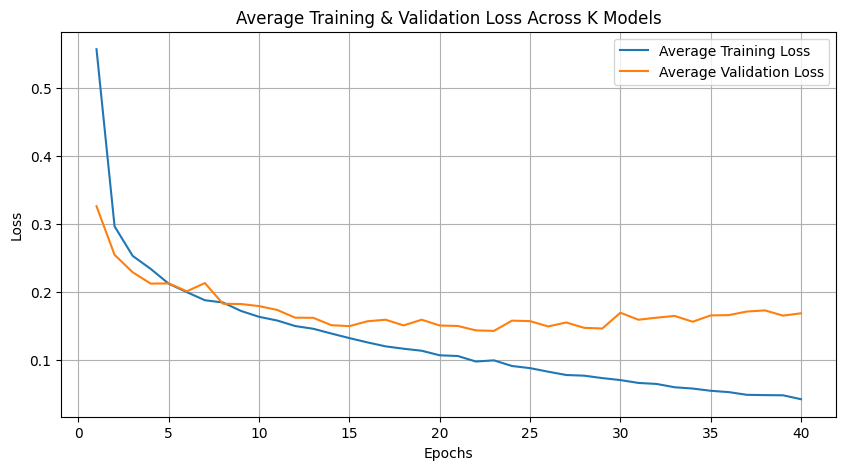

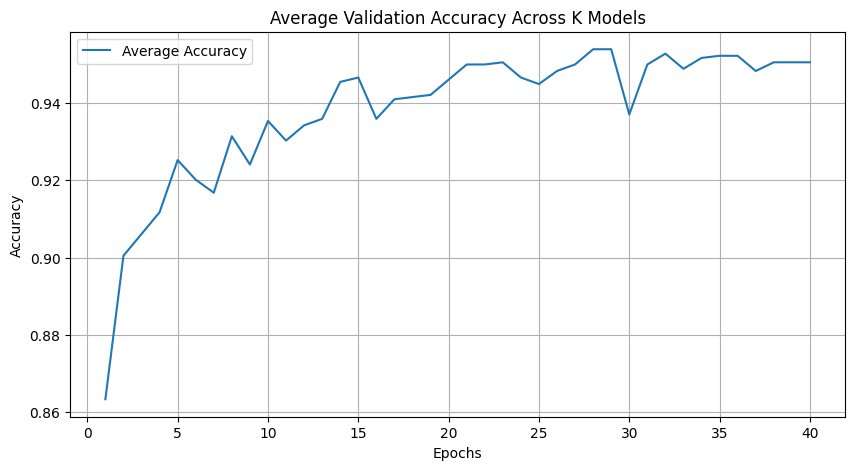

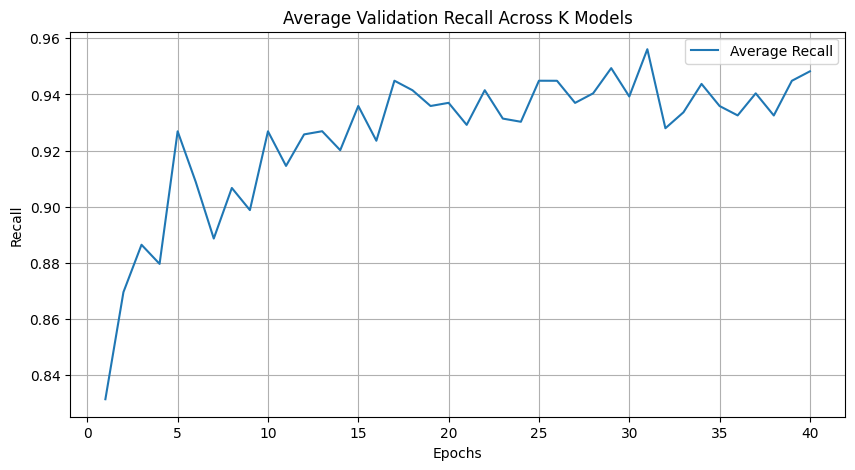


Average Validation Metrics Across All Folds:
Accuracy: 0.9505 ± 0.0129
Recall:   0.9483 ± 0.0043
F1 Score: 0.9506 ± 0.0121


In [ ]:
plot_average_metrics(typical_models_stats)

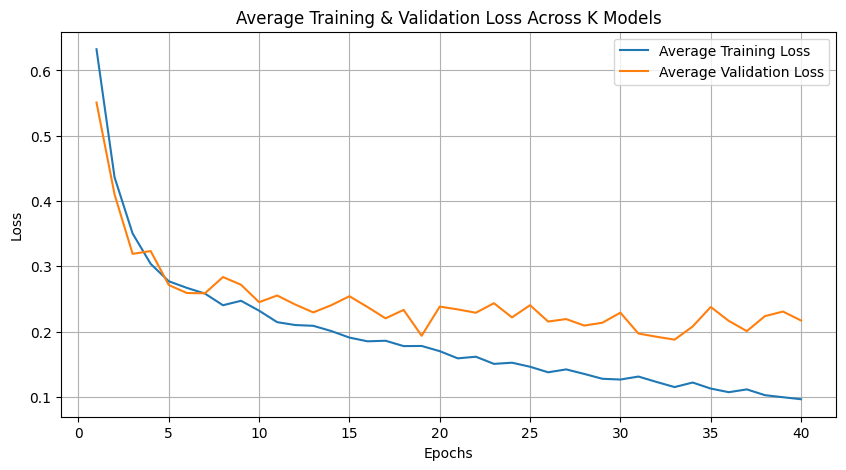

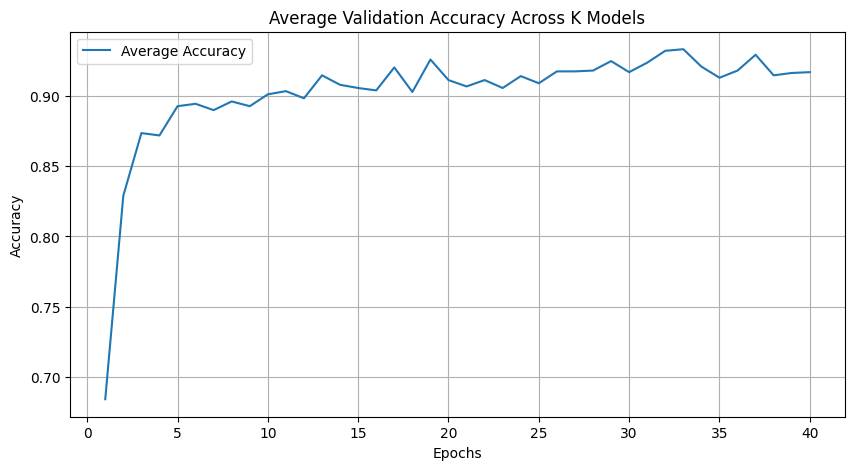

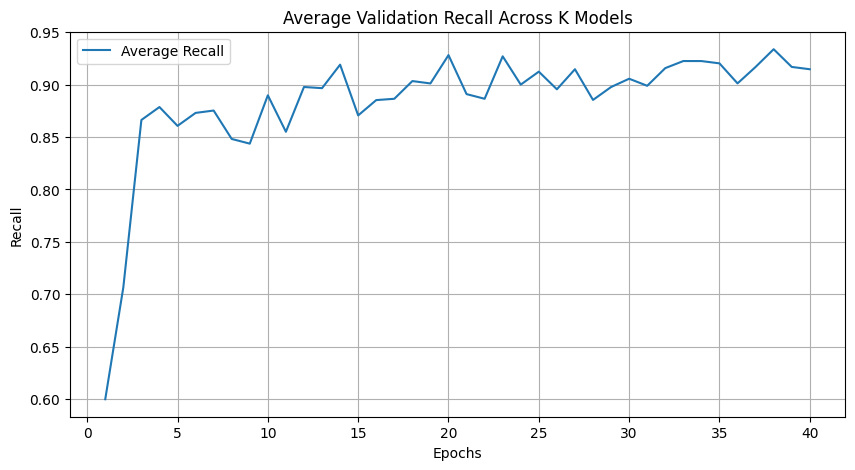


Average Validation Metrics Across All Folds:
Accuracy: 0.9168 ± 0.0173
Recall:   0.9145 ± 0.0510
F1 Score: 0.9160 ± 0.0200


In [ ]:
plot_average_metrics(vim_models_stats_default_head)

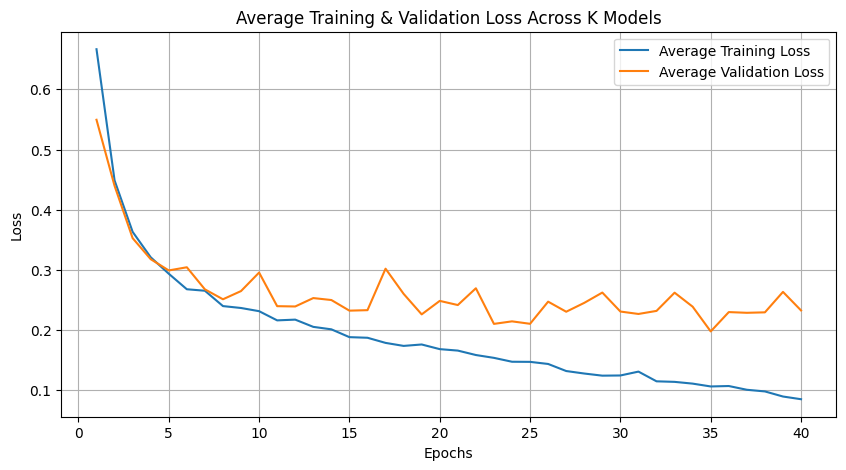

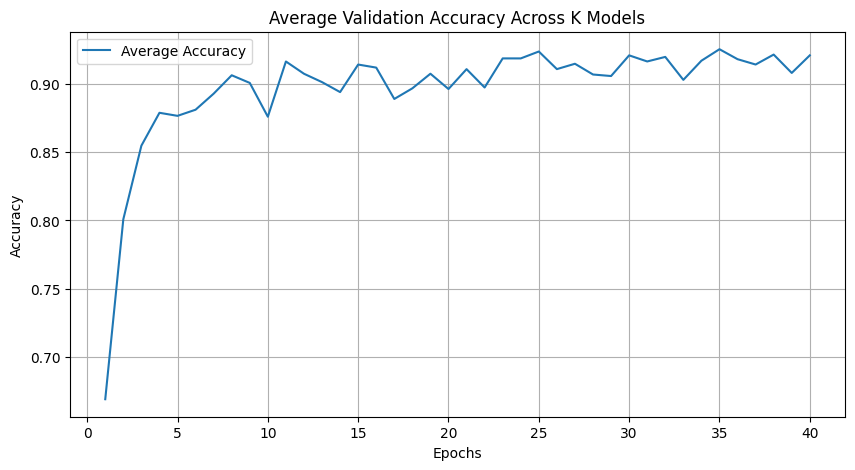

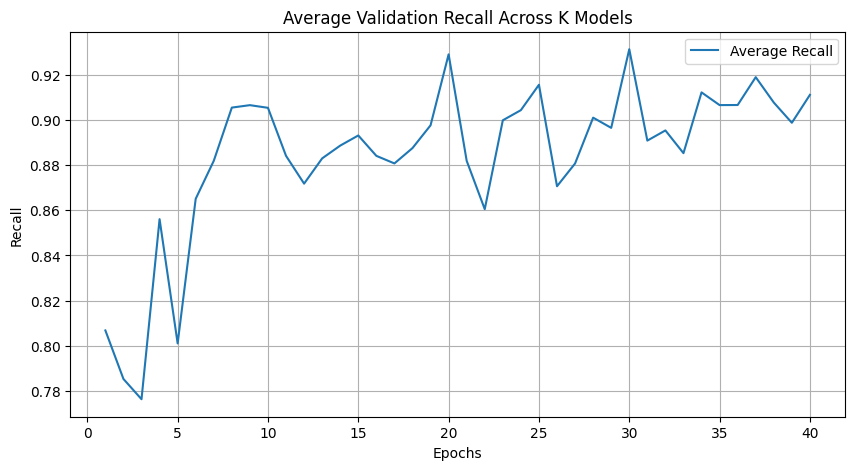


Average Validation Metrics Across All Folds:
Accuracy: 0.9213 ± 0.0164
Recall:   0.9112 ± 0.0339
F1 Score: 0.9203 ± 0.0173


In [ ]:
plot_average_metrics(vim_models_stats_resnet_head)

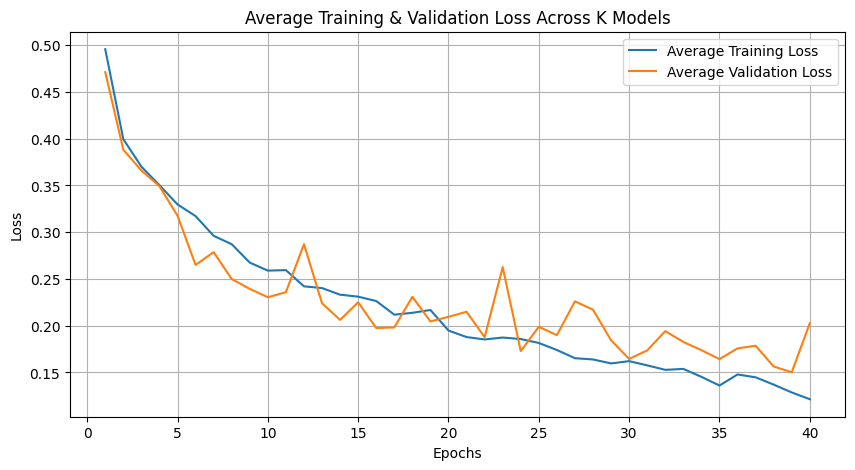

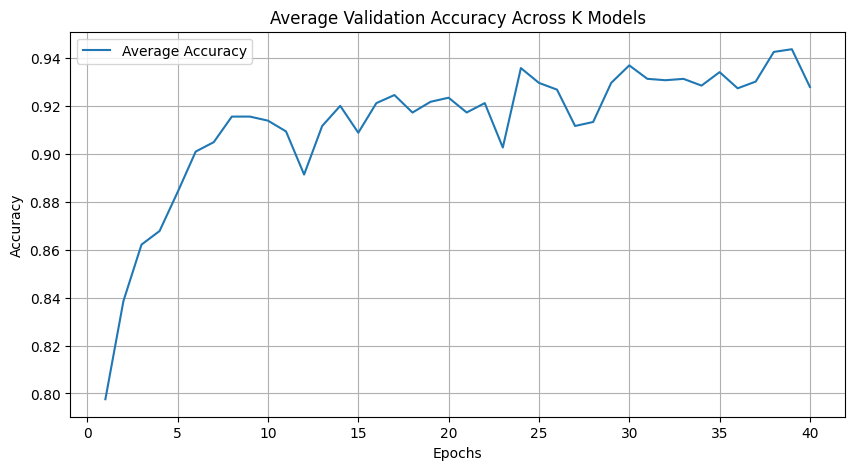

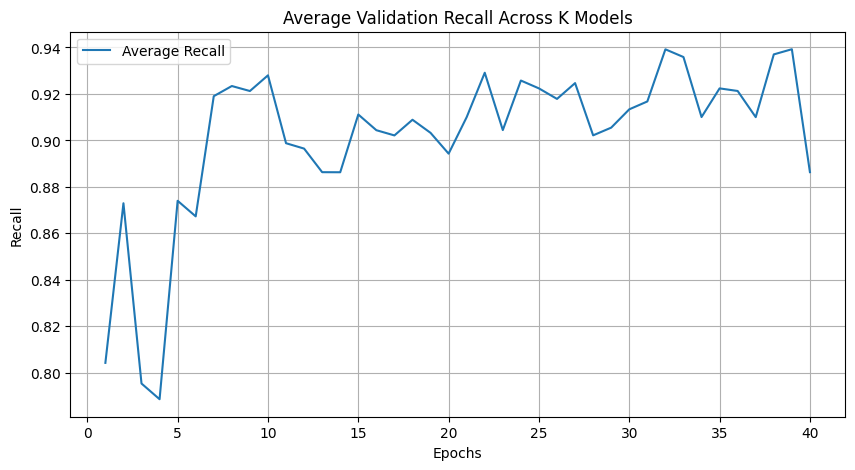


Average Validation Metrics Across All Folds:
Accuracy: 0.9280 ± 0.0228
Recall:   0.8864 ± 0.0604
F1 Score: 0.9240 ± 0.0271


In [ ]:
plot_average_metrics(vim_models_stats_cnn_head)

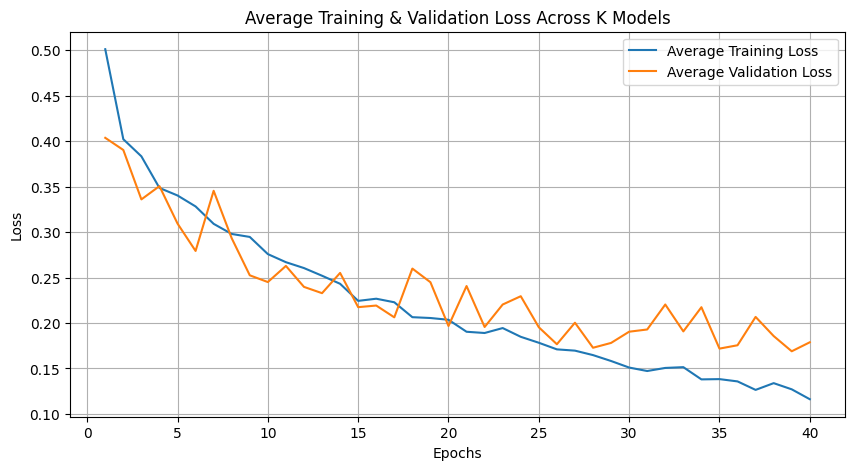

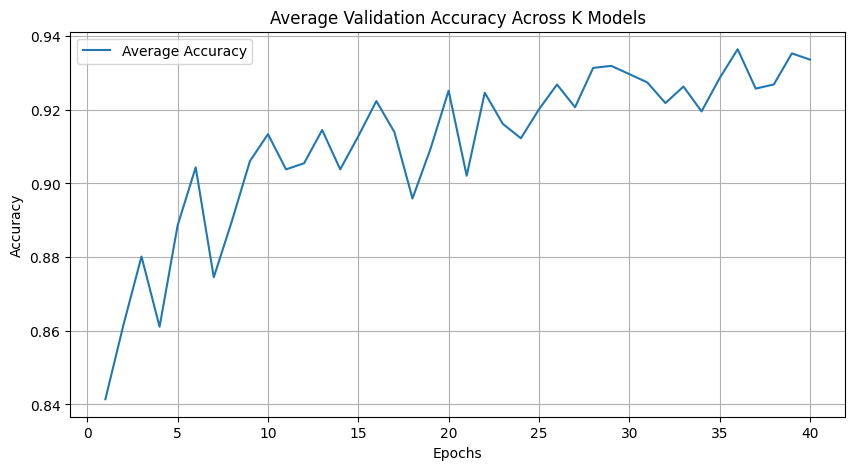

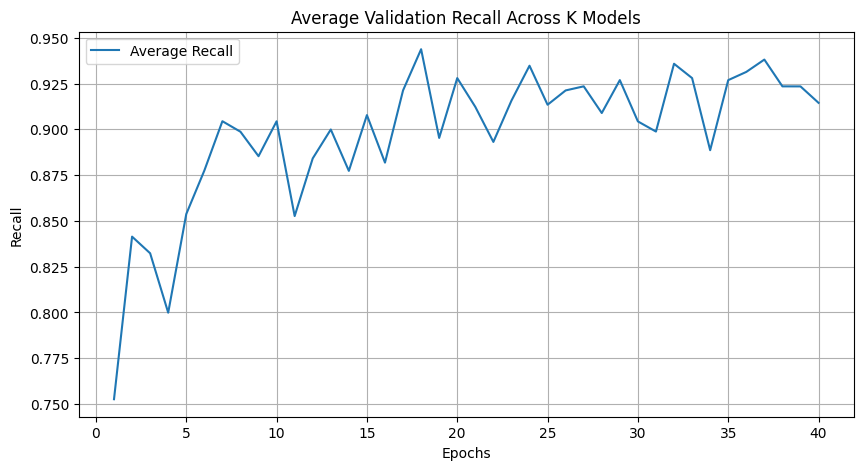


Average Validation Metrics Across All Folds:
Accuracy: 0.9336 ± 0.0101
Recall:   0.9145 ± 0.0210
F1 Score: 0.9323 ± 0.0105


In [39]:
plot_average_metrics(vim_models_stats_cnn_head_mspe)